Look at phase locking / phase precession of goal neurons during flash trial and navigation trials

for a neuron that has a goal-field, whether phase locking vs precession is different when the animal is at the preferred feild or not

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os
import pynwb
import h5py
from tqdm import tqdm
from pathlib import Path 
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LassoCV
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from scipy.signal import resample, find_peaks

import matplotlib
import matplotlib.pyplot as plt
# from matplotlib_venn import venn2
import seaborn as sns

import graph
import load_data
import LFP
import single_neuron_vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class ThetaDataset:
    
    def __init__(self, h5_path):
        self.f = h5py.File(h5_path, 'r')
        self.band_sig = self.f['band_sig']
        self.power = self.f['power']
        self.phase = self.f['phase']

    def get_trace(self, time):
        return self.band_sig[time, :].T, self.power[time, :].T, self.phase[time, :].T

    def get_band_sig(self, time):
        if len(time)==0:
            return self.band_sig[:]
        else:
            return self.band_sig[time, :]

    def get_power(self, time):
        if len(time)==0:
            return self.power[:]
        else:
            return self.power[time, :]

    def get_phase(self, time):
        if len(time)==0:
            return self.phase[:]
        else:
            return self.phase[time, :]

    def close(self):
        self.f.close()

In [3]:
sz1 = 16
sz2 = 18
sz3 = 12
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz3) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [44]:
def plot_sem(time, trace, ax, ii, label):

    colors = sns.color_palette('Set1',4)
    mean_trace = trace.mean(axis=0)
    sem_trace = trace.std(axis=0)/np.sqrt(trace.shape[0])
    ax.plot(time, mean_trace, color=colors[ii], label=label)
    ax.fill_between(time,
                    mean_trace - sem_trace,
                    mean_trace + sem_trace,
                    color=colors[ii],
                    alpha=0.3)

In [23]:
# load tuning of individual neuron characterized with regression model
tuning = pd.read_pickle("D:/SingleNeuron/Tuning flash.pkl")
region = 'OFC'


# get session-level params
ses_info = {'session':['031723','032823','033123','032023','040423','040723','050824',  # Bart
               '101124', '100324', '092124', '092324', '092524', '100124','100924'],
           'animal': ['Bart']*7+['London']*7}
all_sessions = pd.DataFrame(ses_info)  # London
neural_timeseries_index = 0


# get goal encoding neuron using regression coefficient from flahs trials
session_tuning = tuning.query('(region==@region)').copy()
if np.all(np.isnan(session_tuning['unitNumber'].values)):
    session_tuning['unitNumber']=session_tuning['cluster_id']

spatial_ftest_pval =  np.stack(session_tuning['spatial_ftest_pval'].values)
max_node_all = np.stack(session_tuning['max_node_all'].values)
sig_diff_node_all = np.stack(session_tuning['sig_diff_node_all'].values)

idx_min = np.argmin(spatial_ftest_pval,axis=1)
rows = np.arange(spatial_ftest_pval.shape[0])

spatial_pval = spatial_ftest_pval[rows, idx_min]
max_node = max_node_all[rows, idx_min]
sig_node = sig_diff_node_all[rows, idx_min]

# find goal neurons
idx = (spatial_pval<0.001) & (sig_node>0)
goal_neuron = session_tuning.iloc[idx]


In [106]:
tuning[tuning.region=='OFC'])

1671

In [122]:
# check if goal encoding is dependnet on the previous goal
goal_df = pd.DataFrame()

for ii in range(len(all_sessions)):
    
    date = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(animal, date)
    
    results = load_data.load_beh_neural(animal, date, 'OFC', 'reward_on', 'trialerror<2')
    spikes, df, unitNames = results['spikes'], results['beh'], results['unitNames']
    df['pre_target'] = df['block'].map(
        df.groupby('block')['target'].first().shift(1))
        
    trial_idx = (df.trialerror.values==1) & (df.target.values!=df.pre_target.values) #& (df.)
    temp = df.iloc[trial_idx].copy()
    pvalues = np.zeros((len(unitNames),5))
    
    for neuron_idx in range(len(unitNames)):
        
        temp['FR'] = spikes[trial_idx,:500,neuron_idx].sum(axis=1)
    
        # first look at if the neuron encodes the current target
        model = ols('FR ~ C(pre_target)', data=temp).fit()
        pvalues[neuron_idx,0] = model.f_pvalue
    
        # then for each current target, see if its tuning is modulated by the previous target
        # for ii, target in enumerate([1,7,8,14]):
        #     model = ols('FR ~ C(pre_target)', data=temp.query('target==@target')).fit()
        #     pvalues[neuron_idx,ii+1] = model.f_pvalue

    unitNames['reward_goal_pval'] = list(pvalues)
    goal_df = pd.concat([goal_df,unitNames])

all_pval = np.stack(goal_df['reward_goal_pval'].values)
np.mean(all_pval<0.05,axis=0)

Bart 031723
Building Spike Table


720it [00:00, 2942.95it/s]


Bart 032823
Building Spike Table


788it [00:00, 2505.00it/s]


Bart 033123
Building Spike Table


860it [00:00, 3590.24it/s]


Bart 032023
Building Spike Table


1000it [00:00, 4208.91it/s]


Bart 040423
Building Spike Table


996it [00:00, 3167.67it/s]


Bart 040723
Building Spike Table


835it [00:00, 3935.52it/s]


Bart 050824
Building Spike Table


563it [00:00, 1326.52it/s]


London 101124
Building Spike Table


943it [00:00, 1502.67it/s]


London 100324
Building Spike Table


893it [00:00, 1824.18it/s]


London 092124
Building Spike Table


897it [00:00, 1558.83it/s]


London 092324
Building Spike Table


900it [00:00, 1429.56it/s]


London 092524
Building Spike Table


891it [00:00, 1550.15it/s]


London 100124
Building Spike Table


910it [00:00, 1656.81it/s]


London 100924
Building Spike Table


910it [00:00, 1911.30it/s]


array([0.11169514, 1.        , 1.        , 1.        , 1.        ])

C:\Users\ML_4\AppData\Local\Temp\ipykernel_19704\3850898415.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[ii].legend(frameon=False)


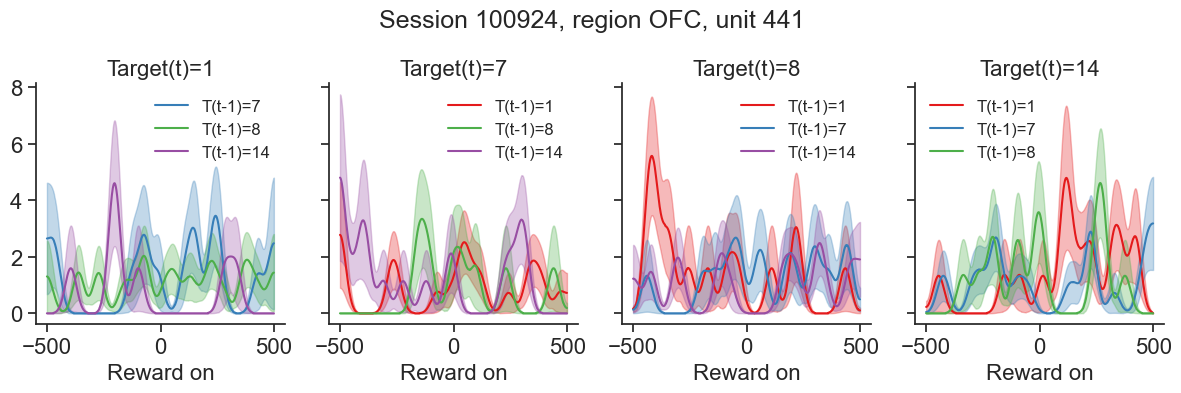

In [130]:
# plotting interaction between current and previous target
targets = [1,7,8,14]
for neuron_idx in range(len(unitNames)):

    unitNumber = unitNames.unitNumber.values[neuron_idx]
        
    plt.close('all')
    fig, axes = plt.subplots(1,4,figsize=(12,4),sharey=True)
    
    for ii, target in enumerate(targets):
        for jj, pre_target in enumerate(targets):
            trial_idx = (df.trialerror.values==1) & (df.target==target) & (df.pre_target==pre_target)
            if trial_idx.sum()>5:
                sdf = single_neuron_vis.get_sdf(spikes[trial_idx,:,neuron_idx],sigma=25)
                plot_sem(np.arange(-500,500), sdf, axes[ii], jj, f'T(t-1)={pre_target}')
            axes[ii].legend(frameon=False)
            axes[ii].set_title(f'Target(t)={target}')
            axes[ii].set_xlabel('Reward on')
    
    plt.tight_layout(rect=[0,0,1,0.9])
    plt.suptitle(f'Session {date}, region {region}, unit {int(unitNumber)}')
    plt.savefig(f'D:/Goal/history_dependent/Session {date}, region {region}, unit {int(unitNumber)}')

In [29]:
for ii in [0]: #range(len(all_sessions)):

    date = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(animal, date)

    # get spatial neurons from a given session
    session_tuning = tuning.query('(Session==@date)&(region==@region)').copy()
    if np.all(np.isnan(session_tuning['unitNumber'].values)):
        session_tuning['unitNumber']=session_tuning['cluster_id']
    
    spatial_ftest_pval =  np.stack(session_tuning['spatial_ftest_pval'].values)
    max_node_all = np.stack(session_tuning['max_node_all'].values)
    sig_diff_node_all = np.stack(session_tuning['sig_diff_node_all'].values)
    
    idx_min = np.argmin(spatial_ftest_pval,axis=1)
    rows = np.arange(spatial_ftest_pval.shape[0])
    
    spatial_pval = spatial_ftest_pval[rows, idx_min]
    max_node = max_node_all[rows, idx_min]
    sig_node = sig_diff_node_all[rows, idx_min]

    # find goal neurons
    idx = (spatial_pval<0.001) & (sig_node>0)
    goal_neuron = session_tuning.iloc[idx]

    
    # load in spikes aligned to a given epoch
    query = 'trialerror==1'
    spike_table = load_data.load_beh_neural(animal, date, region, 'action_on', query)

    # load in behavior
    
    nwbfile = load_data.load_nwbfile(animal, date)
    trial_df = nwbfile.intervals['trials'].to_dataframe().query(query)
    node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)
    choice_df = nwbfile.intervals['action_on'].to_dataframe().query(query)
    fix_df = nwbfile.intervals['fixations'].to_dataframe().query(query)
    
    choice_df['nextnode'] = (
        choice_df
        .groupby('trial')['node']
        .shift(-1)
    )
    
    choice_df['prenode'] = (
        choice_df
        .groupby('trial')['node']
        .shift(1)
    )
    
    # load in LFP for the entire session
    timestamps, lfpData = load_data.load_LFP(date)
    ds = ThetaDataset(f"D:/Theta/Session_{date}_theta.h5")

    # load in spikes for the entire session
    # get good units
    unitNames = nwbfile.units.to_dataframe()
    unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= 2) & (unitNames.fr >= 1))[0]
    unitNames = unitNames.iloc[unit_idx]
    channelNumbers = unitNames.channelNumbers.values - 1

    lfpFile = h5py.File(
        f'D:/Teleworld/bart_I/raw/spikes/Bart_TeleWorld_v13_{date}-spikes.mat', 'r'
    )
    spikeTable = lfpFile['spikeTable'][:len(timestamps), :]


Bart 031723
Building Spike Table


228it [00:00, 530.74it/s]


In [ ]:
# extend time to inter-trial interval

In [24]:
def extract_trial_time(choice_df, fix_df, trial_df, node, neural_timeseries_index=0):
    
    trials = choice_df.query("(node==@node)&(trialerror==0)").trial.values
    n_trials = len(trials)

    fix_node_time = np.full((n_trials, 500), np.nan)
    next_node = np.zeros(n_trials)
    n_ts = np.zeros(n_trials)

    trial_meta = []   # store per-trial info needed later

    for ii, trial in enumerate(trials):

        curr_node = choice_df.query('(trial==@trial)&(node==@node)')
        curr_node_on = curr_node.t_on.values[0]
        next_step = curr_node.step.values[0] + 1

        next_df = choice_df.query('(trial==@trial)&(step==@next_step)')
        next_action_on = next_df.t_on.values[0]
        next_node[ii] = next_df.node.values[0]

        # --- fixation window ---
        temp1 = fix_df.start_time.values < (next_action_on - 500)
        fix_idx1 = int(np.argmin(temp1.astype(int))) - 1

        temp2 = fix_df.stop_time.values > next_action_on
        fix_idx2 = int(np.argmin((~temp2).astype(int)))

        fixations_per_choice = fix_df.iloc[fix_idx1:fix_idx2]

        for _, row in fixations_per_choice.iterrows():
            t_min = int(max(next_action_on - 500, row.start_time) - next_action_on + 500)
            t_max = int(min(next_action_on, row.stop_time) - next_action_on + 500)
            fix_node_time[ii, t_min:t_max] = row.fix_node

        # --- timestamps shared across neurons ---
        trial_ts = trial_df.query("trial==@trial").iloc[0] \
                           .timeseries[neural_timeseries_index].timestamps

        time_idx = (trial_ts >= curr_node_on - 500) & \
                   (trial_ts < next_action_on + 1000)

        n_ts[ii] = np.sum(time_idx)

        trial_meta.append(dict(
            trial=trial,
            curr_node_on=curr_node_on,
            next_action_on=next_action_on,
            time_idx=time_idx
        ))

    return trials, trial_meta, fix_node_time, next_node


In [78]:
spike_table = load_data.load_beh_neural(animal, date, region, 'node_on', query)

Building Spike Table


228it [00:00, 3539.29it/s]


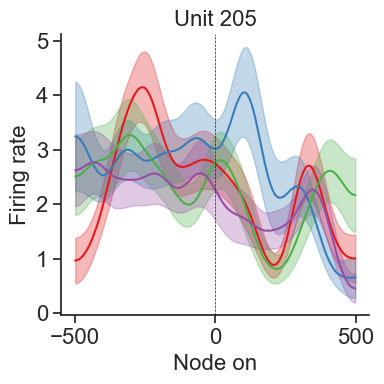

In [82]:
# plot node tuning
for neuronID in goal_neuron.unitNumber.values.astype(int):
    plt.close('all')
    ax = single_neuron_vis.plot_sdf(spike_table, neuronID,'node', sns.color_palette('Set1',16), ax=None)
    ax.set_title(f'Unit {neuronID}')
    ax.set_xlabel('Node on')
    plt.tight_layout()
    plt.savefig(f'D:/Goal/Session {date}, Unit {neuronID}, Flash trial, goal')

In [32]:
def plot_tele_sdf(session, unitNumber, time, aligned, curr_node, next_node, fix_node_time):
    
    # Hypothesis 1, figures
    # plot aligned sdf and fixation probability
    plt.close('all')
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    time = np.arange(-500,500)
    
    for ii, node in enumerate(np.unique(next_node)):
        
        idx = next_node==node
        plot_sem(time, aligned[0,idx,:], axes[0], ii, f'{node}')
        plot_sem(time, aligned[1,idx,:], axes[1], ii, f'{node}')
        
        axes[0].axvline(0,color='k',ls='--')
        axes[1].axvline(0,color='k',ls='--')
    
    axes[2].plot(np.arange(-500,0),np.nanmean(fix_node_time[next_node==15-curr_node,:]==15-curr_node,axis=0))
    axes[2].set_title(f'Fixation on node {15-curr_node}\nNode(t+1) -500ms to 0ms')
    
    axes[1].legend()
    axes[0].set_title(f'Node(t)={curr_node}')
    axes[1].set_title('Node(t+1)')
    axes[0].set_xlabel('Action on(ms)')
    axes[1].set_xlabel('Action on(ms)')

    ymins = []
    ymaxs = []
    for ax in (axes[0], axes[1]):
        ymin, ymax = ax.dataLim.intervaly
        ymins.append(ymin)
        ymaxs.append(ymax)
    axes[0].set_ylim(min(ymins), max(ymaxs))
    axes[1].set_ylim(min(ymins), max(ymaxs))

    plt.tight_layout()

    plt.suptitle(f'Teleport neuron session {session}, HPC unit {unitNumber}')
        
    plt.savefig(f'D:/Teleporter/Teleport neuron session {session}, HPC unit {unitNumber}')

In [121]:
# Extract phase infomation
# start to count theta cycle from node on during flash trial

neuron_idx=71
trials = node_df.trial.values

alltrial = []
alltrial_fix = []

for ii, trial in enumerate(trials):

    node_on = node_df.query('trial==@trial').t_on.values[0]
    trial_stop = trial_df.query('trial==@trial').stop_time.values[0]
    
    # define the time window to look at lfp, spikes, and fixation node
    trial_window = np.arange(node_on - 500, trial_stop + 1500)
    
    # get spikes
    idx = (timestamps >= trial_window[0]) & (timestamps < trial_window[-1])
    cell_trial_spikes = spikeTable[idx,:][:,unit_idx][:,neuron_idx]
    sdf = single_neuron_vis.get_sdf(cell_trial_spikes,sigma=25)
    
    # get lfp
    analytic, power, phase = ds.get_trace(idx)
    channel = int(unitNames.channelNumbers.iloc[neuron_idx])-1
    phase_unwrapped = np.unwrap(phase[channel,:])
    node_on_phase = phase_unwrapped[trial_window[:-1]==node_on]
    
    
    alltrial.append(np.array([trial_window[:-1]-node_on,
                             cell_trial_spikes,
                             analytic[channel,:],
                              phase[channel,:],
                              phase_unwrapped-node_on_phase]))


In [ ]:
# plot sdf from node on to ITI, unit 159

In [129]:
for neuron_idx in goal_neuron.index.astype(int):

    print(f"Processing neuron {neuron_idx}")

    trials = node_df.trial.values

    # =========================
    # Build trial-aligned data
    # =========================
    alltrial = []
    alltrial_fix = []

    for ii, trial in enumerate(trials):

        node_on = node_df.query('trial==@trial').t_on.values[0]
        trial_stop = trial_df.query('trial==@trial').stop_time.values[0]

        # time window
        trial_window = np.arange(node_on - 500, trial_stop + 1500)

        # spikes
        idx = (timestamps >= trial_window[0]) & (timestamps < trial_window[-1])
        cell_trial_spikes = spikeTable[idx, :][:, unit_idx][:, neuron_idx]

        # LFP
        analytic, power, phase = ds.get_trace(idx)
        channel = int(unitNames.channelNumbers.iloc[neuron_idx]) - 1

        phase_unwrapped = np.unwrap(phase[channel, :])
        node_on_phase = phase_unwrapped[trial_window[:-1] == node_on]

        alltrial.append(
            np.array([
                trial_window[:-1] - node_on,      # time from node-on
                cell_trial_spikes,                 # spikes
                analytic[channel, :],              # analytic signal
                phase[channel, :],                 # wrapped phase
                phase_unwrapped - node_on_phase    # phase relative to node-on
            ])
        )

    # =========================
    # Plotting
    # =========================
    all_tau = []
    all_phase = []

    colors = sns.color_palette('Set1', 4)
    targets = [1, 7, 8, 14]

    plt.close('all')
    fig, axes = plt.subplots(
        4, 1,
        figsize=(5, 8),
        sharey=True,
        sharex=True,
        constrained_layout=True
    )

    for jj, target in enumerate(targets):

        ax = axes[jj]
        subtrials = np.where(choice_df.target.values == target)[0]

        for ii in subtrials:
            this_trial = alltrial[ii]
            tau, cycle_idx, spike_idx = cycle_normalized_time(this_trial)

            ax.scatter(
                tau,
                this_trial[3, spike_idx],
                marker="|",
                color=colors[jj],
                s=20
            )

            mask = (tau > -5) & (tau < 5)
            all_tau.append(tau[mask])
            all_phase.append(this_trial[3, spike_idx[mask]])

        ax.set_title(f"Target {target}", fontsize=10)
        ax.axvline(0, color='k', linestyle='--', linewidth=0.5)
        ax.set_ylim(-np.pi, np.pi)

    # shared labels
    axes[-1].set_xlabel("Cycle-normalized time")
    fig.text(0.02, 0.5, "Theta phase (rad)", va="center", rotation="vertical")

    # suptitle + save
    unitNumber = unitNames.iloc[neuron_idx].unitNumber
    fig.suptitle(f"Unit {unitNumber}", fontsize=12)

    plt.savefig(
        f"D:/Goal/Theta phase raster, Session {date}, unit {unitNumber}",
        dpi=300,
        bbox_inches="tight"
    )
    plt.close(fig)


Processing neuron 1
Processing neuron 4
Processing neuron 10
Processing neuron 12
Processing neuron 13
Processing neuron 23
Processing neuron 27
Processing neuron 28
Processing neuron 30
Processing neuron 37
Processing neuron 40
Processing neuron 41
Processing neuron 42
Processing neuron 43
Processing neuron 44
Processing neuron 64
Processing neuron 65
Processing neuron 66
Processing neuron 68
Processing neuron 69
Processing neuron 70
Processing neuron 71
Processing neuron 72
Processing neuron 73
Processing neuron 74
Processing neuron 75
Processing neuron 76
Processing neuron 77
Processing neuron 78
Processing neuron 79


In [ ]:
# align theta-cycle normalized time to current action onset

In [44]:
def cycle_normalized_time(this_trial):
    
    """
    spike_idx   : spike times in samples
    trough_idx  : theta trough indices (samples)
    
    Returns:
        tau        : normalized time within cycle [0,1]
        cycle_idx  : theta cycle index for each spike
    """
    
    # find theta troughs
    trough_idx,_ = find_peaks(-this_trial[3,:],distance=100)
    
    # get spikes indices
    spike_idx = np.where(this_trial[1,:])[0]
    
    # assign each spike to a cycle
    cycle_idx = np.searchsorted(trough_idx, spike_idx, side='right') 
    
    valid = (cycle_idx >= 0) & (cycle_idx < len(trough_idx)-1)
    spike_idx = spike_idx[valid]
    cycle_idx = cycle_idx[valid]
    
    t0 = trough_idx[cycle_idx]
    t1 = trough_idx[cycle_idx + 1]
    
    tau = (spike_idx - t0) / (t1 - t0) + cycle_idx

    
    time0_idx = np.where(this_trial[0,:]==0)[0][0]
    time0_cycle_idx = np.searchsorted(trough_idx, time0_idx, side='right') 
    time0 = (time0_idx - trough_idx[time0_cycle_idx]) / (trough_idx[time0_cycle_idx+1] - trough_idx[time0_cycle_idx]) + time0_cycle_idx
    
    return tau-time0, cycle_idx, spike_idx


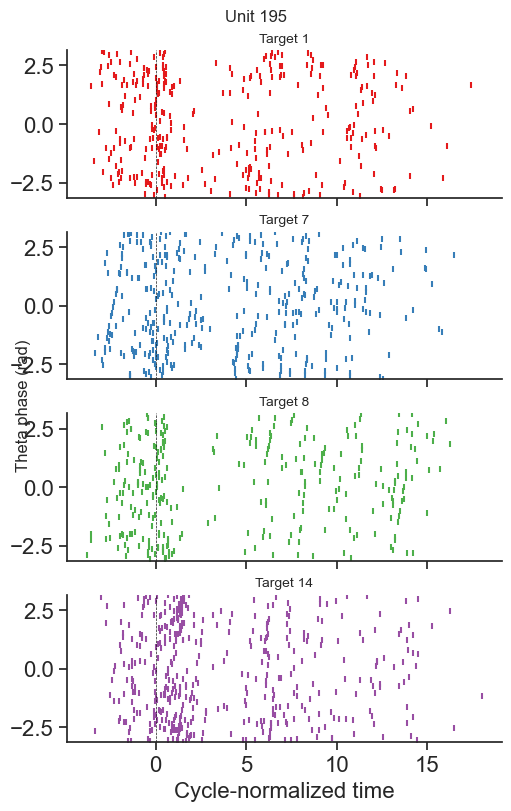

In [128]:
all_tau = []
all_phase = []

colors = sns.color_palette('Set1', 4)
targets = [1, 7, 8, 14]

plt.close('all')
fig, axes = plt.subplots(
    4, 1,
    figsize=(5, 8),
    sharey=True,
    sharex=True,
    constrained_layout=True
)

for jj, target in enumerate(targets):

    ax = axes[jj]
    subtrials = np.where(choice_df.target.values == target)[0]

    for ii in subtrials:
        this_trial = alltrial[ii]
        tau, cycle_idx, spike_idx = cycle_normalized_time(this_trial)

        ax.scatter(
            tau,
            this_trial[3, spike_idx],
            marker="|",
            color=colors[jj],
            s=20
        )

        mask = (tau > -5) & (tau < 5)
        all_tau.append(tau[mask])
        all_phase.append(this_trial[3, spike_idx[mask]])

    ax.set_title(f"Target {target}", fontsize=10)
    ax.axvline(0, color='k', linestyle='--', linewidth=0.5)
    ax.set_ylim(-np.pi, np.pi)

# shared labels
axes[-1].set_xlabel("Cycle-normalized time")
fig.text(0.02, 0.5, "Theta phase (rad)", va="center", rotation="vertical")

# suptitle (now safe)
unitNumber = unitNames.iloc[neuron_idx].unitNumber
fig.suptitle(f"Unit {unitNumber}", fontsize=12)

plt.savefig(
    f"D:/Goal/Theta phase raster, Session {date}, unit {unitNumber}",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


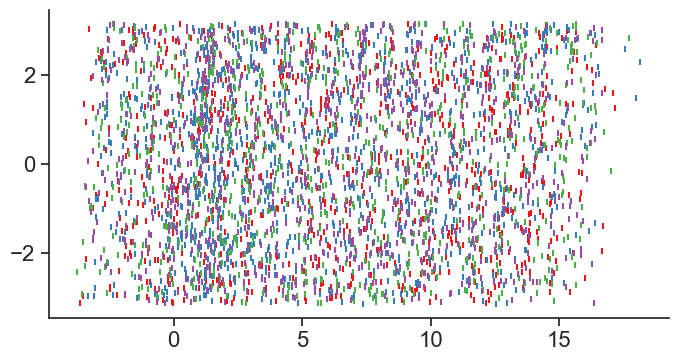

In [117]:
all_tau = []
all_phase = []
colors = sns.color_palette('Set1',4)
plt.close('all')
fig, axes = plt.subplots(figsize=(8,4))

for jj, target in enumerate([1,7,8,14]):
    
    subtrials = np.where(choice_df.target.values==target)[0]
    
    for _,ii in enumerate(subtrials):
        
        this_trial = alltrial[ii]
        tau, cycle_idx, spike_idx = cycle_normalized_time(this_trial)
        axes.scatter(tau,this_trial[3,spike_idx], marker = "|", color=colors[jj], s=20)
        
        all_tau.append(tau[(tau>-5)&(tau<5)])
        all_phase.append(this_trial[3,spike_idx[(tau>-5)&(tau<5)]])

plt.ylim(-np.pi,np.pi)

In [226]:
from pycircstat2.correlation import circ_corrcl
results = circ_corrcl(np.hstack(all_phase), np.hstack(all_tau))

TypeError: cannot unpack non-iterable CorrelationResult object

(-2000.0, 2000.0)

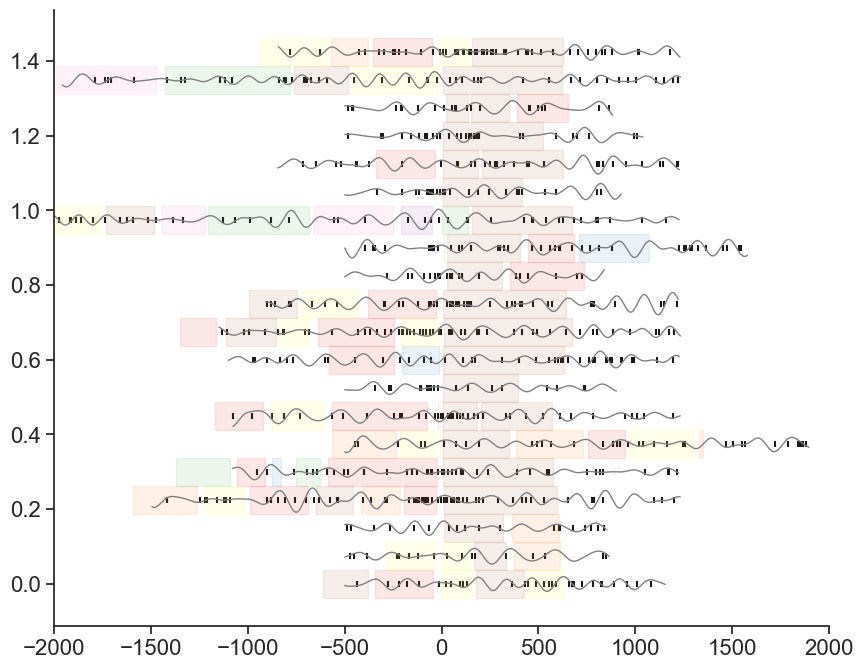

In [94]:
# time, spikes, lfp, fixation node

colors = sns.color_palette('Set1',16)

plt.close('all')
fig, axes = plt.subplots(figsize=(10,8))
scale = 0.075

for ii in range(20):
    
    X, Y = np.where(alltrial[ii][1,:].reshape(1,-1))
    axes.plot(alltrial[ii][0,:],alltrial[ii][2,:]+ii*scale,color='grey',lw=1)
    axes.scatter(Y+alltrial[ii][0,0], X+ii*scale, marker = "|", c="k", s=20)

    for ff in range(len(alltrial_fix[ii])):
        axes.fill_betweenx([ii*scale-scale/2, ii*scale+scale/2],alltrial_fix[ii][ff,0],alltrial_fix[ii][ff,1],
                           color = colors[int(alltrial_fix[ii][ff,2])],alpha=0.1)


plt.xlim(-2000,2000)

In [ ]:
look at theta power, when it is above 3sd, whether there is a pattern

In [ ]:
# get data aligned to node 0 and then node 15 in a trial, choice fixations

colors = sns.color_palette('Set1',16)

nodes = [0,15]

tele_trials = choice_df.query("(use_tele) & (target==14)").copy()
trial_idx = tele_trials.trial.unique()
ts = np.arange(-500,1500)
sample_data = np.zeros((2,len(trial_idx),2000))*np.nan
start_times_all = np.zeros((2,len(trial_idx)))

for ii, tt in enumerate(trial_idx):
    
    trial_timeseries = trial_df.query("trial==@tt").iloc[0].timeseries[neural_timeseries_index]
    trial_ts = trial_timeseries.timestamps
    trial_spikes = trial_timeseries.data[:,unit_idx]
    cell_trial_spikes = (trial_spikes[:,31]+trial_spikes[:,34])>0
    
    choices_per_trial = choice_df.query("trial==@tt")
    choice_idx = np.where((choices_per_trial.node==nodes[1])&(choices_per_trial.prenode==nodes[0]))[0][0]
    choices_per_trial = choices_per_trial.iloc[choice_idx-1:choice_idx+1,:]
    start_times = choices_per_trial.t_on.values
    start_times_all[:,ii] = start_times
    
    for jj in range(2):
        
        time_idx = (trial_ts >= start_times[jj] - 500) & (trial_ts < start_times[jj] + 1500)
        sample_data[jj,ii,:] = cell_trial_spikes[time_idx]


# sort spikes by node, choice fixations

plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(8,5),facecolor=(1, 1, 1))

for jj in range(2):
    # plot spike raster
    X, Y = np.where(sample_data[jj])
    axs[jj].scatter(Y-500, X+45, marker = "|", c="k", s=20)
    axs[jj].plot(np.arange(-500,1500),movmean(sample_data[jj].mean(axis=0)*1000, w=75).flatten(),'k-')
    sns.despine()
    
    
    for ii, tt in enumerate(trial_idx):
    
        fix_idx = ((fix_df.start_time >= start_times_all[jj,ii] - 500) & (fix_df.start_time < start_times_all[jj,ii] + 1500)) | \
                    ((fix_df.stop_time >= start_times_all[jj,ii] - 500) & (fix_df.stop_time < start_times_all[jj,ii] + 1500)) 
        fixations_per_choice = fix_df[fix_idx]
    
        fixation_starts = fixations_per_choice.start_time.values - start_times_all[jj,ii] 
        fixation_stops = fixations_per_choice.stop_time.values - start_times_all[jj,ii] 
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for ff in range(len(fixations_per_choice)):
            axs[jj].fill_betweenx([ii+45-0.5, ii+45+0.5],fixation_starts[ff],fixation_stops[ff],color = colors[fixation_nodes[ff]],alpha=0.01)
    
    axs[jj].set_xlim(-500,1500)
    axs[jj].set_xlabel('Action on, Node '+str(nodes[jj]))
    
    if jj==1:
        axs[jj].set_yticks([])
        axs[jj].spines[['left','right', 'top']].set_visible(False)
    else:
        axs[jj].set_ylabel('Trial number')

    axs[jj].plot([0,0],[0,90],'k--')
    axs[jj].set_ylim(5,90)
    

for cc in [0,14,15]:
    axs[jj].fill_betweenx([0, 0],0,0,color = colors[cc],alpha=0.1,label='Node '+str(cc))
    
plt.legend(loc=(0.45,0.25),frameon=False)
plt.suptitle('Teleport: 0 -> 15')
plt.savefig('HPC Unit 88 teleport 0 to 15.jpg')